# Data analysis: Interacting with R packages

In this vignette we cover the most basic steps to convert an anndata object to a SingleCellExperiment and perform analyses using R-based packages.

Please follow the installation instructions to setup a conda environment containing both Python and R.
In order to setup the R-Python interface, we add `R_HOME` to the environment variables. Here, we use a generic expression pointing to the path of the currently used conda environment and its relative location where R is stored.

We next activate anndata2ri and load the jupyter extension from rpy2.

In [1]:
import FACSPy as fp

In [2]:
import os
from pathlib import Path

os.environ["R_HOME"] = os.path.join(Path(os.environ["CONDA_PREFIX"]), Path("lib/R/"))
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

C:\Users\tarik\AppData\Local\Temp\ipykernel_32520\453632031.py:6: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
C:\Users\tarik\anaconda3\envs\facspy_r\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


## Dataset loading and conversion

We create the dataset using FACSPy and perform `fp.r_setup()`. This function is necessary due to type inflictions from anndata2ri that have to be solved beforehand. We also split the `.uns` slot and the `.obsm["gating"]` slot from the anndata, since `.uns` contains custom data types (such as `fp.dt.Metadata`, `fp.dt.Panel` etc.) and the gating information is not really needed outside of FACSPy. If you want to keep the gating information, set the respective parameter to `False`.

In [3]:
adata = fp.mouse_lineages()

In [4]:
adata, uns, gating = fp.r_setup(adata)

Next, we use the `%%R` magic command and the `-i` flag. This converts adata to one of its' R-equivalents, a SingleCellExperiment.

## Performing FlowSOM clustering using Spectre

Next, we proceed in the jupyter interface and calculate the FlowSOM clustering information using Spectre.

In [5]:
%%R -i adata

adata

class: SingleCellExperiment 
dim: 20 9210 
metadata(0):
assays(2): compensated transformed
rownames(20): FSC-A FSC-H ... CD45 Time
rowData names(7): pns png ... pnn cofactors
colnames(9210): 4225-25 61597-5 ... 3624-67 44545-41
colData names(8): sample_ID file_name ... age staining
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


At this point, you may save the SingleCellExperiment using `saveRDS` and continue in your native R enviroment. This is recommended if the setup of the environments is too cumbersome. Later, we show how to re-read a saved (and potentially modified) SingleCellExperiment and convert it back to python.

In [6]:
%%R
library(Spectre)
library(SingleCellExperiment)

In [7]:
%%R
dt_sce <- Spectre::create.dt(adata)

cell.dat <- dt_sce$data.table

matchfor <- c("transformed")
matchPat <- paste0(matchfor, "\\w?\\b")
idxs <- lapply(matchPat, grep, names(cell.dat))

cluster.cols <- names(cell.dat)[idxs[[1]]]

cell.dat <- run.flowsom(cell.dat, cluster.cols, meta.k = 8)


Exception ignored from cffi callback <function _consolewrite_ex at 0x000001C787ABE200>:
Traceback (most recent call last):
  File "C:\Users\tarik\anaconda3\envs\facspy_r\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\tarik\anaconda3\envs\facspy_r\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf6 in position 6: invalid start byte
Exception ignored from cffi callback <function _consolewrite_ex at 0x000001C787ABE200>:
Traceback (most recent call last):
  File "C:\Users\tarik\anaconda3\envs\facspy_r\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\tarik\anaconda3\envs\facspy_r\lib\site-packages\rpy2\rinter

data.table 1.15.2 using 12 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attache Paket: 'data.table'

Das folgende Objekt ist maskiert 'package:SummarizedExperiment':

    shift

Das folgende Objekt ist maskiert 'package:GenomicRanges':

    shift

Das folgende Objekt ist maskiert 'package:IRanges':

    shift

Die folgenden Objekte sind maskiert von 'package:S4Vectors':

    first, second

SingleCellExperiment detected
-- Adding metadata
-- Adding assay data
-- Adding DimRed data
-- Finalising
Converted a SingleCellExperiment object into a data.table stored in a list

Attache Paket: 'igraph'

Das folgende Objekt ist maskiert 'package:GenomicRanges':

    union

Das folgende Objekt ist maskiert 'package:IRanges':

    union

Das folgende Objekt ist maskiert 'package:S4Vectors':

    union

Die folgenden Objekte sind maskiert von 'package:BiocGenerics':

    normalize, path, union

Die folgenden Objekte sind maskiert von 'package:stats':

    decompose, spectrum

Das folge

We append the relevant cluster information to the SingleCell experiment.  

Next, we export the SingleCellExperiment back to anndata using the `-o` command.

In order to restore the old dataset, we use `fp.r_restore()`. This adds the `.uns` slot and the `.obsm["gating"]` slot back.

We see that FlowSOM clusters and FlowSOM metaclusters have been added to the .obs column of the dataset.

In [8]:
%%R -o adata

colData(adata)$FlowSOM_clusters <- cell.dat$FlowSOM_cluster
colData(adata)$FlowSOM_metacluster <- cell.dat$FlowSOM_metacluster

adata

class: SingleCellExperiment 
dim: 20 9210 
metadata(0):
assays(2): compensated transformed
rownames(20): FSC-A FSC-H ... CD45 Time
rowData names(7): pns png ... pnn cofactors
colnames(9210): 4225-25 61597-5 ... 3624-67 44545-41
colData names(10): sample_ID file_name ... FlowSOM_clusters
  FlowSOM_metacluster
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


fp.r_restore(adata, uns = uns, gating_matrix = gating)
adata

In [9]:
adata.obs

,sample_ID,file_name,organ,genotype,sex,experiment,age,staining,FlowSOM_clusters,FlowSOM_metacluster
4225-25,26,21112023_lineage_BM_M10_014.fcs,BM,neg,f,2,95,stained,172.0,5
61597-5,6,20112023_lineage_BM_M4_041.fcs,BM,pos,m,1,95,stained,116.0,5
17511-50,51,22112023_lineage_BM_M14_012.fcs,BM,pos,m,3,96,stained,161.0,8
42884-49,50,22112023_lineage_BM_M13_011.fcs,BM,pos,m,3,96,stained,101.0,5
54157-30,31,21112023_lineage_BM_M9_013.fcs,BM,neg,f,2,95,stained,5.0,2
...,...,...,...,...,...,...,...,...,...,...
5793-19,20,20112023_lineage_SPL_M3_048.fcs,SPL,pos,f,1,95,stained,190.0,8
20707-70,71,22112023_lineage_SPL_M18_024.fcs,SPL,neg,m,3,96,stained,190.0,8
7544-46,47,21112023_lineage_SPL_M9_021.fcs,SPL,neg,f,2,95,stained,190.0,8
3624-67,68,22112023_lineage_SPL_M15_021.fcs,SPL,pos,m,3,96,stained,189.0,8


Next, we want to plot a dimensionality reduction using CATALYST.

For this, we need to add two columns in `adata.var` and `adata.obs`, respectively in order to matcht the requirements by CATALYST.

We convert the anndata object as described above and run the `R` functions.

In [10]:
adata.var["marker_class"] = ["type" if type == "fluo" else "state" for type in adata.var["type"].tolist()]
adata.obs["sample_id"] = adata.obs["sample_ID"]

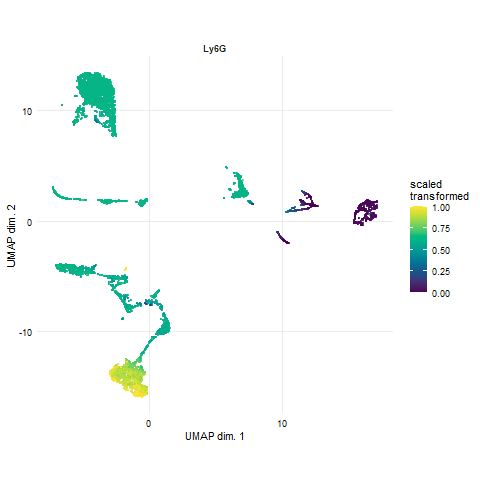

In [11]:
%%R  -i adata
library(CATALYST)
adata <- runDR(adata, dr = "UMAP", cells = 2000, features = "type", assay = "transformed")
plotDR(adata, dr = "UMAP", color_by = "Ly6G", assay = "transformed")

We see that a new slot has been created for the UMAP coordinates. This slot can be readily accessed using anndata.

In [12]:
%%R -o adata

adata

class: SingleCellExperiment 
dim: 20 9210 
metadata(0):
assays(2): X transformed
rownames(20): FSC-A FSC-H ... CD45 Time
rowData names(8): pns png ... cofactors marker_class
colnames(9210): 4225-25 61597-5 ... 3624-67 44545-41
colData names(11): sample_ID file_name ... FlowSOM_metacluster
  sample_id
reducedDimNames(1): UMAP
mainExpName: NULL
altExpNames(0):


In [13]:
adata.obsm.keys()

KeysView(AxisArrays with keys: X_umap)

## Reread saved RDS files

In order to convert SingleCellExperiments back that were modified in another R environment, read the RDS file and convert it to anndata via the `-o` command.

In [14]:
%%R -o sce

saveRDS(adata, "my_data.rds")

sce <- readRDS("my_data.rds")

In [15]:
sce

AnnData object with n_obs × n_vars = 9210 × 20
    obs: 'sample_ID', 'file_name', 'organ', 'genotype', 'sex', 'experiment', 'age', 'staining', 'FlowSOM_clusters', 'FlowSOM_metacluster', 'sample_id'
    var: 'pns', 'png', 'pne', 'pnr', 'type', 'pnn', 'cofactors', 'marker_class'
    obsm: 'X_umap'
    layers: 'transformed'